# Anomaly Detection Challenge

This notebook experiments with different anomaly detection algorithms on the HEP dataset.
We'll compare Isolation Forest and Flow Matching approaches.

In [1]:
# Import necessary libraries
import numpy as np
import os
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    accuracy_score,
    RocCurveDisplay,
)
import time

# Import fAD components
from fad.data.loaders import _load_h5_challenge_dataset
from fad.data.preprocessing import Preprocessor, StandardScalerFunction, TSNEFunction
from fad.models.statistical import IsolationForestDetector
from fad.models.flow_matching import FlowMatchingAnomalyDetector
from fad.models.NNs import MLP_wrapper

In [2]:
import hls4ml

## 1. Data Loading and Exploration

In [3]:
# Set paths to dataset files
path_bkg = (
    "/home/fvaselli/Documents/PHD/fAD/fad/data/ad_challenge/background_for_training.h5"
)
path_anom = "/home/fvaselli/Documents/PHD/fAD/fad/data/ad_challenge/Ato4l_lepFilter_13TeV_filtered.h5"

# Load challenge datasets
print("Loading datasets...")
dataset = _load_h5_challenge_dataset(path_bkg, path_anom, n_train=3000000, n_test=60000)

# Print dataset information
print(f"Training set shape: {dataset.train.shape}")
print(f"Test set shape: {dataset.test.shape}")
print(f"Number of anomalies in test set: {np.sum(dataset.test_labels)}")

# dataset 2 with different anomaly process
path_anom2 = "/home/fvaselli/Documents/PHD/fAD/fad/data/ad_challenge/leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5"

# Load challenge datasets
print("Loading datasets...")
dataset2 = _load_h5_challenge_dataset(
    path_bkg, path_anom2, n_train=100000, n_test=400000
)
# Print dataset information
print(f"Training set shape: {dataset2.train.shape}")
print(f"Test set shape: {dataset2.test.shape}")
print(f"Number of anomalies in test set: {np.sum(dataset2.test_labels)}")

Loading datasets...
Discarding type index, shape bkg: (3060000, 19, 3), shape anom: (55969, 19, 3)
Training set shape: (3000000, 57)
Test set shape: (115969, 57)
Number of anomalies in test set: 55969.0
Loading datasets...
Discarding type index, shape bkg: (500000, 19, 3), shape anom: (340544, 19, 3)
Training set shape: (100000, 57)
Test set shape: (740544, 57)
Number of anomalies in test set: 340544.0


## 2. Data Preprocessing

In [4]:
# Preprocess data with standardization
print("Preprocessing data...")
preprocessor = Preprocessor([StandardScalerFunction()])
X_train = preprocessor.transform(dataset.train, fit=True)
X_test = preprocessor.transform(dataset.test)
print("Done")
X_test2 = preprocessor.transform(dataset2.test)

Preprocessing data...
Done


## 4. Train and Evaluate Models

We'll train and evaluate two models:
1. Isolation Forest (traditional algorithm)
2. Flow Matching (advanced generative model)

In [5]:
# Dictionary to store results
results = {}

### 4.1 Isolation Forest

In [6]:
print("Training Isolation Forest...")
start_time = time.time()
iso_forest = IsolationForestDetector(contamination=0.01)
iso_forest.fit(X_train)
iso_time = time.time() - start_time
print(f"Training time: {iso_time:.2f} seconds")

# Predict anomaly scores
iso_scores = iso_forest.predict(X_test)
iso_auc = roc_auc_score(dataset.test_labels, iso_scores)
iso_ap = average_precision_score(dataset.test_labels, iso_scores)
iso_accuracy = accuracy_score(dataset.test_labels, iso_scores < 0)
print(f"Accuracy: {iso_accuracy:.4f}")
print(f"AUC-ROC: {iso_auc:.4f}")
print(f"Average Precision: {iso_ap:.4f}")

# for dataset2
iso_scores2 = iso_forest.predict(X_test2)
iso_auc2 = roc_auc_score(dataset2.test_labels, iso_scores2)
iso_ap2 = average_precision_score(dataset2.test_labels, iso_scores2)
iso_accuracy2 = accuracy_score(dataset2.test_labels, iso_scores2 < 0)
print(f"Accuracy: {iso_accuracy2:.4f}")
print(f"AUC-ROC: {iso_auc2:.4f}")
print(f"Average Precision: {iso_ap2:.4f}")


results["Isolation Forest"] = {
    "scores": iso_scores,
    "auc": iso_auc,
    "ap": iso_ap,
    "time": iso_time,
}

Training Isolation Forest...
Training time: 10.89 seconds
Accuracy: 0.4268
AUC-ROC: 0.8662
Average Precision: 0.8401
Accuracy: 0.4132
AUC-ROC: 0.8455
Average Precision: 0.8010


In [7]:
print(X_train.shape[1])

57


### 4.2 Flow Matching

In [8]:
config_path = "../fad/models/configs/flow_matching.yaml"
with open(config_path, "r") as f:
    config = yaml.safe_load(f)
# flow_matching  = FlowMatchingAnomalyDetector(
#     input_dim=X_train.shape[1],
#     hidden_dim=config["hidden_dim"],
#     model_type=config["model_type"],
#     num_layers=config["num_layers"],
#     dropout_rate=config["dropout_rate"],
#     use_batch_norm=config["use_batch_norm"],
#     lr=config["lr"],
#     batch_size= config["batch_size"],
#     iterations=config["iterations"],
#     print_every=config["print_every"],
#     device=config["device"],
# )
# flow_matching.load("flow_matching_model.pt")

print("Training Flow Matching (this may take a while)...")
# load the model config from the config file
# use absolute path to avoid issues with relative paths: get my parent folder, then go to fad/models/configs/flow_matching.yaml
config_path = "../fad/models/configs/flow_matching.yaml"
with open(config_path, "r") as f:
    config = yaml.safe_load(f)
start_time = time.time()
flow_matching = FlowMatchingAnomalyDetector(
    input_dim=X_train.shape[1],
    hidden_dim=config["hidden_dim"],
    model_type=config["model_type"],
    num_layers=config["num_layers"],
    dropout_rate=config["dropout_rate"],
    use_batch_norm=config["use_batch_norm"],
    lr=config["lr"],
    batch_size=config["batch_size"],
    reflow_steps=config["reflow_steps"],
    reflow_batches=config["reflow_batches"],
    iterations=config["iterations"],
    print_every=config["print_every"],
    device=config["device"],
)
flow_matching.fit(X_train, mode="OT", reflow=True)
flow_time = time.time() - start_time
print(f"Training time: {flow_time:.2f} seconds")

Training Flow Matching (this may take a while)...
| iter      1 | 5963.89 ms/step | loss    1.359 
| iter      2 | 9389.42 ms/step | loss    1.325 
| iter      3 | 16667.84 ms/step | loss    1.238 
| iter      4 | 10221.39 ms/step | loss    1.273 
| iter      5 | 9841.42 ms/step | loss    1.226 
Training time: 52.49 seconds


In [9]:
# Predict anomaly scores
flow_scores = flow_matching.predict(X_test, mode="vt")
# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for normal samples: {np.mean(flow_scores[dataset.test_labels == 0]):.4f}"
)
print(
    f"Std score for normal samples: {np.std(flow_scores[dataset.test_labels == 0]):.4f}"
)
print(
    f"Mean score for anomalous samples: {np.mean(flow_scores[dataset.test_labels == 1]):.4f}"
)
print(
    f"Std score for anomalous samples: {np.std(flow_scores[dataset.test_labels == 1]):.4f}"
)
flow_auc = roc_auc_score(dataset.test_labels, flow_scores)
flow_ap = average_precision_score(dataset.test_labels, flow_scores)
flow_accuracy = accuracy_score(dataset.test_labels, flow_scores > 10)
# manually compute accuracy
print(f"Accuracy: {flow_accuracy:.4f}")
print(f"AUC-ROC: {flow_auc:.4f}")
print(f"Average Precision: {flow_ap:.4f}")

results["Flow Matching vt"] = {
    "scores": flow_scores,
    "auc": flow_auc,
    "ap": flow_ap,
    "time": 1,
}

# now again in ODE mode
flow_scores, transformed_data = flow_matching.predict(
    X_test, mode="ode", time_steps=2, step_size=None, return_transformed_data=True
)
# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for normal samples: {np.mean(flow_scores[dataset.test_labels == 0]):.4f}"
)
print(
    f"Std score for normal samples: {np.std(flow_scores[dataset.test_labels == 0]):.4f}"
)
print(
    f"Mean score for anomalous samples: {np.mean(flow_scores[dataset.test_labels == 1]):.4f}"
)
print(
    f"Std score for anomalous samples: {np.std(flow_scores[dataset.test_labels == 1]):.4f}"
)
flow_auc = roc_auc_score(dataset.test_labels, flow_scores)
flow_ap = average_precision_score(dataset.test_labels, flow_scores)
flow_accuracy = accuracy_score(dataset.test_labels, flow_scores > 10)
# manually compute accuracy
print(f"Accuracy: {flow_accuracy:.4f}")
print(f"AUC-ROC: {flow_auc:.4f}")
print(f"Average Precision: {flow_ap:.4f}")
results["Flow Matching ode"] = {
    "scores": flow_scores,
    "auc": flow_auc,
    "ap": flow_ap,
    "time": 1,
}

Mean score for normal samples: 2.4566
Std score for normal samples: 6.9556
Mean score for anomalous samples: 56.0388
Std score for anomalous samples: 134.0215
Accuracy: 0.7239
AUC-ROC: 0.8626
Average Precision: 0.8719
time grid: tensor([1., 0.])
Mean score for normal samples: 70.6463
Std score for normal samples: 472.9446
Mean score for anomalous samples: 8056.5591
Std score for anomalous samples: 38473.5781
Accuracy: 0.4826
AUC-ROC: 0.8736
Average Precision: 0.8768


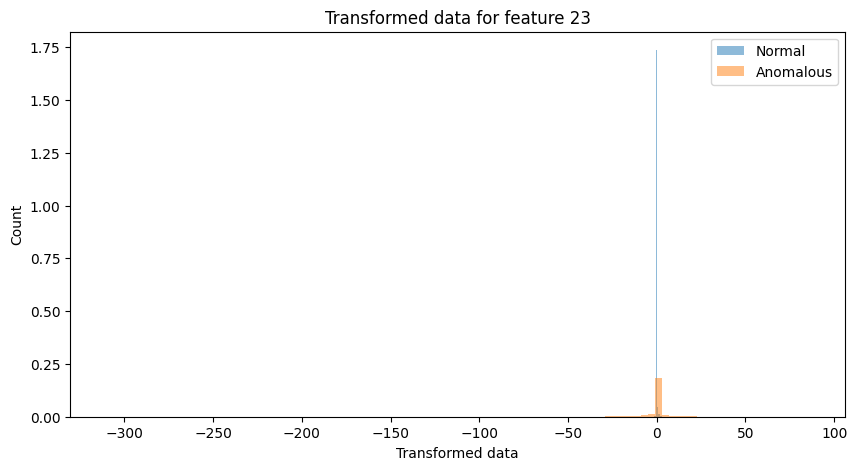

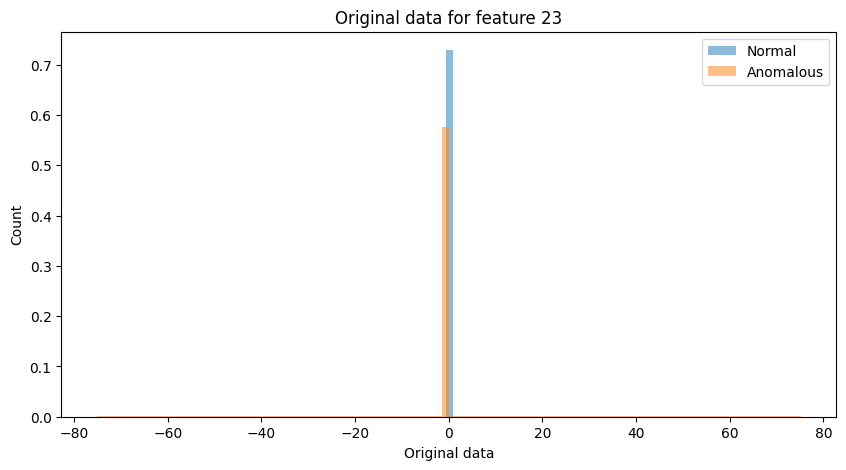

In [10]:
# plot an histogram of transformed data for one of the features
n_feature = 23
plt.figure(figsize=(10, 5))
plt.hist(
    transformed_data[dataset.test_labels == 0][:, n_feature],
    bins=100,
    alpha=0.5,
    label="Normal",
    density=True,
)
plt.hist(
    transformed_data[dataset.test_labels == 1][:, n_feature],
    bins=100,
    alpha=0.5,
    label="Anomalous",
    density=True,
)
plt.xlabel("Transformed data")
plt.ylabel("Count")
plt.title(f"Transformed data for feature {n_feature}")
plt.legend()
plt.show()

# now for the original dataset X_test
plt.figure(figsize=(10, 5))
plt.hist(
    X_test[dataset.test_labels == 0][:, n_feature],
    bins=100,
    alpha=0.5,
    label="Normal",
    density=True,
)
plt.hist(
    X_test[dataset.test_labels == 1][:, n_feature],
    bins=100,
    alpha=0.5,
    label="Anomalous",
    density=True,
)
plt.xlabel("Original data")
plt.ylabel("Count")
plt.title(f"Original data for feature {n_feature}")
plt.legend()
plt.show()

In [11]:
# Predict anomaly scores
flow_scores2 = flow_matching.predict(X_test2, mode="vt")
# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for normal samples: {np.mean(flow_scores2[dataset2.test_labels == 0]):.4f}"
)
print(
    f"Std score for normal samples: {np.std(flow_scores2[dataset2.test_labels == 0]):.4f}"
)
print(
    f"Mean score for anomalous samples: {np.mean(flow_scores2[dataset2.test_labels == 1]):.4f}"
)
print(
    f"Std score for anomalous samples: {np.std(flow_scores2[dataset2.test_labels == 1]):.4f}"
)
flow_auc2 = roc_auc_score(dataset2.test_labels, flow_scores2)
flow_ap2 = average_precision_score(dataset2.test_labels, flow_scores2)
flow_accuracy2 = accuracy_score(dataset2.test_labels, flow_scores2 > 10)
# manually compute accuracy
print(f"Accuracy: {flow_accuracy2:.4f}")
print(f"AUC-ROC: {flow_auc2:.4f}")
print(f"Average Precision: {flow_ap2:.4f}")

results["Flow Matching2 vt"] = {
    "scores": flow_scores2,
    "auc": flow_auc2,
    "ap": flow_ap2,
    "time": 1,
}
# now again in ODE mode
flow_scores2 = flow_matching.predict(
    X_test2, mode="ode", time_steps=2, step_size=None, log_density_calc="library"
)
# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for normal samples: {np.mean(flow_scores2[dataset2.test_labels == 0]):.4f}"
)
print(
    f"Std score for normal samples: {np.std(flow_scores2[dataset2.test_labels == 0]):.4f}"
)
print(
    f"Mean score for anomalous samples: {np.mean(flow_scores2[dataset2.test_labels == 1]):.4f}"
)
print(
    f"Std score for anomalous samples: {np.std(flow_scores2[dataset2.test_labels == 1]):.4f}"
)
flow_auc2 = roc_auc_score(dataset2.test_labels, flow_scores2)
flow_ap2 = average_precision_score(dataset2.test_labels, flow_scores2)
flow_accuracy2 = accuracy_score(dataset2.test_labels, flow_scores2 > 10)
# manually compute accuracy
print(f"Accuracy: {flow_accuracy2:.4f}")
print(f"AUC-ROC: {flow_auc2:.4f}")
print(f"Average Precision: {flow_ap2:.4f}")
results["Flow Matching2 ode"] = {
    "scores": flow_scores2,
    "auc": flow_auc2,
    "ap": flow_ap2,
    "time": 1,
}

Mean score for normal samples: 2.4671
Std score for normal samples: 7.2382
Mean score for anomalous samples: 10.5641
Std score for anomalous samples: 23.8576
Accuracy: 0.6299
AUC-ROC: 0.7810
Average Precision: 0.7536
time grid: tensor([1., 0.])
Mean score for normal samples: 42.8389
Std score for normal samples: 639.1786
Mean score for anomalous samples: 284.4523
Std score for anomalous samples: 4279.0537
Accuracy: 0.4636
AUC-ROC: 0.7873
Average Precision: 0.7584


## 5. Model Comparison and Visualization

Isolation Forest
Flow Matching vt
Flow Matching ode
Flow Matching2 vt
Flow Matching2 ode


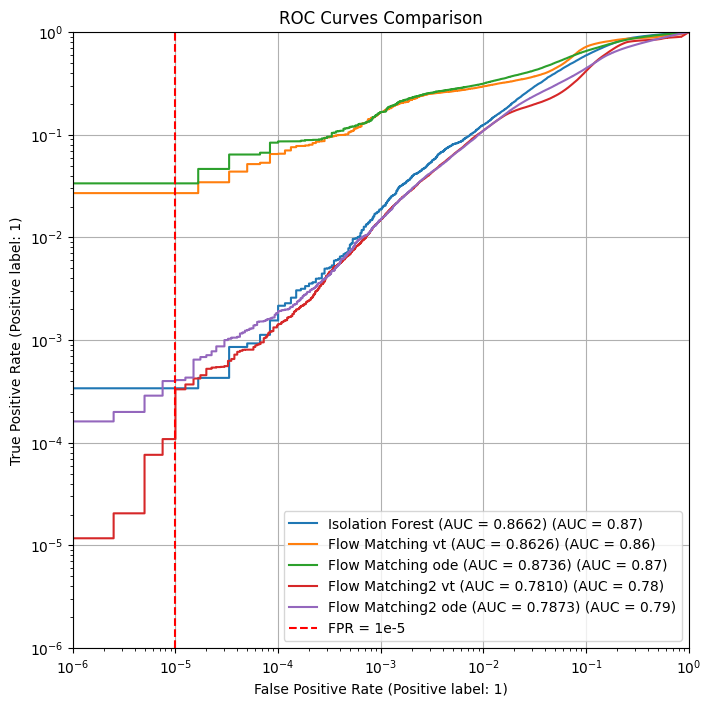

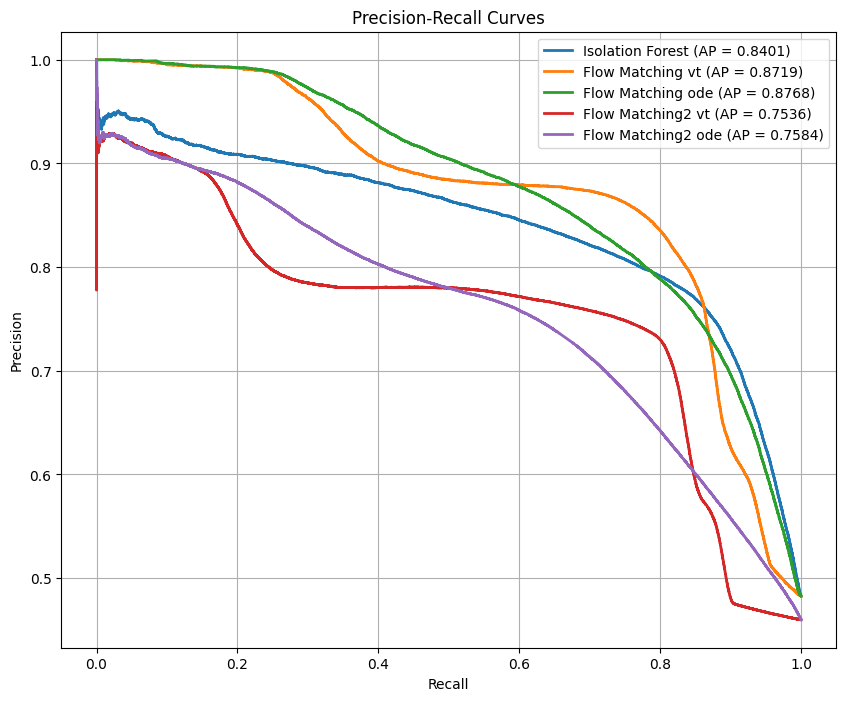

In [12]:
# Compare ROC curves
plt.figure(figsize=(10, 8))
# remove "Flow Mathcing2" form results
for name, result in results.items():
    print(name)
    if (name == "Flow Matching2 vt") | (name == "Flow Matching2 ode"):
        # use the second dataset for this model
        RocCurveDisplay.from_predictions(
            dataset2.test_labels,
            result["scores"],
            name=f"{name} (AUC = {result['auc']:.4f})",
            ax=plt.gca(),
        )
    else:
        RocCurveDisplay.from_predictions(
            dataset.test_labels,
            result["scores"],
            name=f"{name} (AUC = {result['auc']:.4f})",
            ax=plt.gca(),
        )

plt.axvline(x=1e-5, color="red", linestyle="--", label="FPR = 1e-5")
plt.xscale("log")
plt.yscale("log")
plt.xlim([1e-6, 1])
plt.ylim([1e-6, 1])
plt.title("ROC Curves Comparison")
plt.grid(True)
plt.legend()
plt.show()

# Compare Precision-Recall curves
plt.figure(figsize=(10, 8))
for name, result in results.items():
    if (name == "Flow Matching2 vt") | (name == "Flow Matching2 ode"):
        # use the second dataset for this model
        precision, recall, _ = precision_recall_curve(
            dataset2.test_labels, result["scores"]
        )
        plt.plot(recall, precision, lw=2, label=f"{name} (AP = {result['ap']:.4f})")
    else:
        precision, recall, _ = precision_recall_curve(
            dataset.test_labels, result["scores"]
        )
        plt.plot(recall, precision, lw=2, label=f"{name} (AP = {result['ap']:.4f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.grid(True)
plt.show()

## 6. Score Distributions

In [13]:
# Visualize anomaly scores distribution
plt.figure(figsize=(12, 6))

for i, (name, result) in enumerate(results.items(), 1):
    if name != "Flow Matching":
        continue
    plt.subplot(1, 1, 1)

    # Separate scores for normal and anomaly classes
    if name == "Flow Matching2":
        # use the second dataset for this model
        normal_scores = result["scores"][dataset2.test_labels == 0]
        print(normal_scores.shape)
        anomaly_scores = result["scores"][dataset2.test_labels == 1]
    else:
        normal_scores = result["scores"][dataset.test_labels == 0]
        print(normal_scores.shape)
        anomaly_scores = result["scores"][dataset.test_labels == 1]

    if any(anomaly_scores > 1000):
        anomaly_scores[anomaly_scores > 1000] = 1000
        normal_scores[normal_scores > 1000] = 1000
        print(f"mean score for normal samples: {np.median(normal_scores)}")
        print(f"mean score for anomalous samples: {np.mean(anomaly_scores)}")
    # Plot histograms
    sns.histplot(normal_scores, color="blue", alpha=0.5, label="Normal", bins=100)
    sns.histplot(anomaly_scores, color="red", alpha=0.5, label="Anomaly", bins=100)

    plt.title(f"{name} Score Distribution")
    plt.legend()

plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

torch.Size([2, 5, 57])
torch.Size([2, 5, 57])


Text(0.5, 0.01, '○: Initial state   •: Intermediate states   ★: Final state')

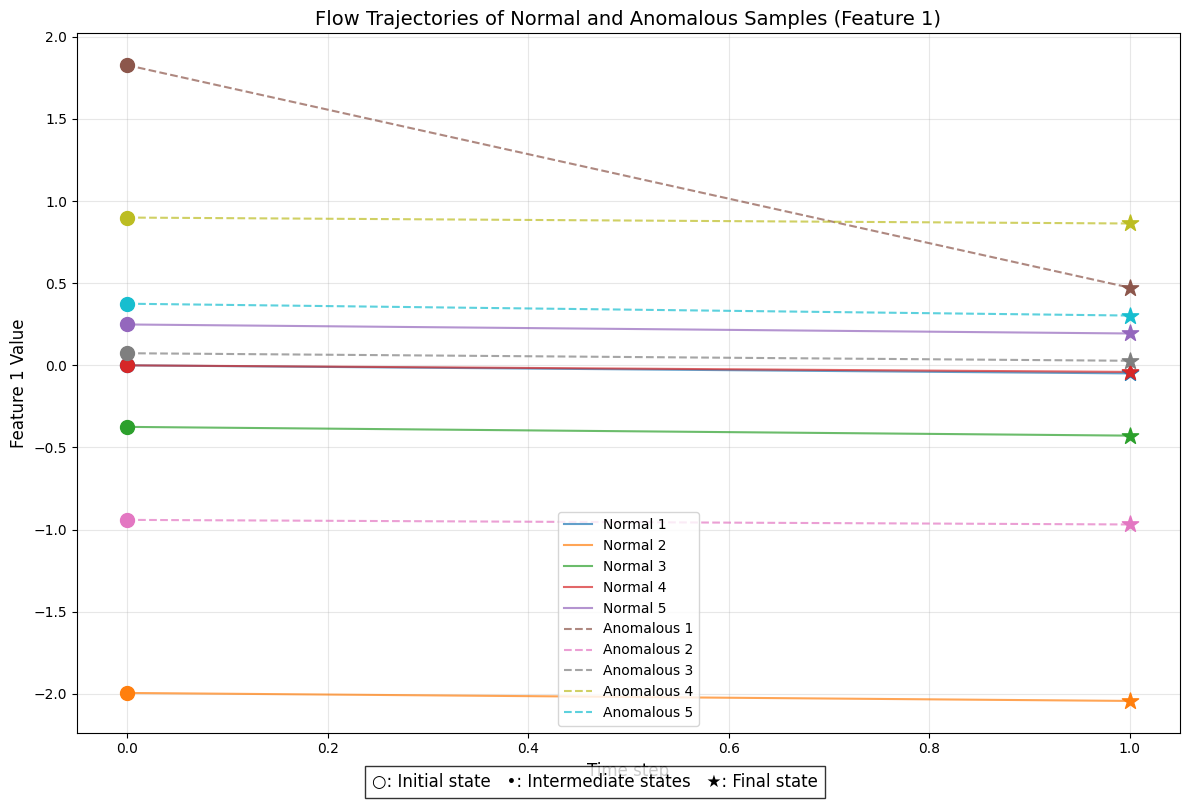

In [14]:
# try and plot some trajectories for normal and anomalous samples
# get the indices of the normal and anomalous samples
normal_indices = np.where(dataset.test_labels == 0)[0]
anomalous_indices = np.where(dataset.test_labels == 1)[0]
# get the first 5 indices of each
normal_indices = normal_indices[:5]
anomalous_indices = anomalous_indices[:5]
# plot the trajectories for the normal samples
normal_trajectories = flow_matching.return_trajectories(
    X_test[normal_indices],
    mode="ODE",
    time_steps=2,
).swapaxes(0, 1)
anom_trajectories = flow_matching.return_trajectories(
    X_test[anomalous_indices],
    mode="ODE",
    time_steps=2,
).swapaxes(0, 1)

# Create a figure for the first feature trajectory visualization
plt.figure(figsize=(12, 8))

# Plot the trajectories
for i, trajectory in enumerate(normal_trajectories):
    plt.plot(trajectory[:, 4], label=f"Normal {i + 1}", color=f"C{i}", alpha=0.7)
    # Add small scatter points for all states
    plt.scatter(
        range(len(trajectory)),
        trajectory[:, 4],
        marker=".",
        color=f"C{i}",
        s=20,
        alpha=0.5,
    )
    # Highlight initial and final states
    plt.scatter(0, trajectory[0, 4], marker="o", color=f"C{i}", s=100, zorder=10)
    plt.scatter(
        len(trajectory) - 1,
        trajectory[-1, 4],
        marker="*",
        color=f"C{i}",
        s=150,
        zorder=10,
    )

for i, trajectory in enumerate(anom_trajectories):
    plt.plot(
        trajectory[:, 4],
        label=f"Anomalous {i + 1}",
        linestyle="--",
        color=f"C{i + 5}",
        alpha=0.7,
    )
    # Add small scatter points for all states
    plt.scatter(
        range(len(trajectory)),
        trajectory[:, 4],
        marker=".",
        color=f"C{i + 5}",
        s=20,
        alpha=0.5,
    )
    # Highlight initial and final states
    plt.scatter(0, trajectory[0, 4], marker="o", color=f"C{i + 5}", s=100, zorder=10)
    plt.scatter(
        len(trajectory) - 1,
        trajectory[-1, 4],
        marker="*",
        color=f"C{i + 5}",
        s=150,
        zorder=10,
    )

# Add visual enhancements
plt.title("Flow Trajectories of Normal and Anomalous Samples (Feature 1)", fontsize=14)
plt.xlabel("Time step", fontsize=12)
plt.ylabel("Feature 1 Value", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc="best", fontsize=10)
plt.tight_layout()

# Add a text annotation explaining the markers
plt.figtext(
    0.5,
    0.01,
    "○: Initial state   •: Intermediate states   ★: Final state",
    ha="center",
    fontsize=12,
    bbox={"facecolor": "white", "alpha": 0.8, "pad": 5},
)

## 7. Results Summary

In [15]:
# Create a summary table
print("==== Summary of Results ====")
print(f"{'Model':<20} {'AUC-ROC':<10} {'Avg Precision':<15} {'Training Time (s)':<15}")
print("-" * 60)
for name, result in results.items():
    print(
        f"{name:<20} {result['auc']:<10.4f} {result['ap']:<15.4f} {result['time']:<15.2f}"
    )

==== Summary of Results ====
Model                AUC-ROC    Avg Precision   Training Time (s)
------------------------------------------------------------
Isolation Forest     0.8662     0.8401          10.89          
Flow Matching vt     0.8626     0.8719          1.00           
Flow Matching ode    0.8736     0.8768          1.00           
Flow Matching2 vt    0.7810     0.7536          1.00           
Flow Matching2 ode   0.7873     0.7584          1.00           
